In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
class ESC50Dataset(Dataset):
    """Custom Dataset for ESC-50 audio classification"""

    def __init__(self, csv_file, audio_dir, feature_extractor, max_length=16000*5):
        """
        Args:
            csv_file: Path to metadata CSV file
            audio_dir: Directory containing audio files
            feature_extractor: Wav2Vec2 feature extractor
            max_length: Maximum audio length (5 seconds at 16kHz)
        """
        self.metadata = pd.read_csv(csv_file)
        self.audio_dir = audio_dir
        self.feature_extractor = feature_extractor
        self.max_length = max_length

        # Encode labels
        self.label_encoder = LabelEncoder()
        self.metadata['encoded_target'] = self.label_encoder.fit_transform(self.metadata['target'])

        print(f"Dataset loaded: {len(self.metadata)} samples")
        print(f"Number of classes: {len(self.label_encoder.classes_)}")

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Get metadata
        row = self.metadata.iloc[idx]
        audio_path = os.path.join(self.audio_dir, row['filename'])
        label = row['encoded_target']

        # Load audio
        try:
            audio, sr = librosa.load(audio_path, sr=16000)

            # Pad or truncate to fixed length
            if len(audio) > self.max_length:
                audio = audio[:self.max_length]
            else:
                audio = np.pad(audio, (0, self.max_length - len(audio)))

        except Exception as e:
            print(f"Error loading {audio_path}: {e}")
            # Return zeros if audio loading fails
            audio = np.zeros(self.max_length)

        # Process with feature extractor
        inputs = self.feature_extractor(
            audio,
            sampling_rate=16000,
            return_tensors="pt",
            padding=True
        )

        return {
            'input_values': inputs.input_values.squeeze(),
            'label': torch.tensor(label, dtype=torch.long),
            'filename': row['filename']
        }

In [4]:
class Wav2Vec2Classifier(nn.Module):
    """Wav2Vec2-based audio classifier"""

    def __init__(self, model_name="facebook/wav2vec2-base", num_classes=50, freeze_base=False):
        super().__init__()

        # Load pretrained Wav2Vec2
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(model_name)

        # Freeze base model if specified
        if freeze_base:
            for param in self.wav2vec2.parameters():
                param.requires_grad = False

        # Classification head
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.wav2vec2.config.hidden_size, num_classes)

    def forward(self, input_values, attention_mask=None):
        # Extract features
        outputs = self.wav2vec2(input_values, attention_mask=attention_mask)

        # Global average pooling over sequence dimension
        hidden_states = outputs.last_hidden_state
        pooled_output = torch.mean(hidden_states, dim=1)

        # Classification
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

In [5]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, batch in enumerate(dataloader):
        input_values = batch['input_values'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        # Forward pass
        logits = model(input_values)
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}')

    accuracy = correct_predictions / total_samples
    return total_loss / len(dataloader), accuracy

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_values = batch['input_values'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_values)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct_predictions / total_samples
    return total_loss / len(dataloader), accuracy, all_predictions, all_labels

In [6]:
sample_metadata = {
    'filename': [f'audio_{i:04d}.wav' for i in range(100)],
    'fold': np.random.randint(1, 6, 100),
    'target': np.random.randint(0, 50, 100),
    'category': [f'class_{i%10}' for i in range(100)]
}
sample_df = pd.DataFrame(sample_metadata)
sample_df.to_csv('sample_esc50_meta.csv', index=False)

print("Sample ESC-50 metadata created for demonstration")
print(sample_df.head())

Sample ESC-50 metadata created for demonstration
         filename  fold  target category
0  audio_0000.wav     2      10  class_0
1  audio_0001.wav     2       7  class_1
2  audio_0002.wav     4      35  class_2
3  audio_0003.wav     4      34  class_3
4  audio_0004.wav     5      41  class_4


In [7]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

In [8]:
print("\nCreating dummy audio files for demonstration...")
os.makedirs('dummy_audio', exist_ok=True)

for i in range(10):  # Create 10 dummy audio files
    # Generate 5 seconds of dummy audio at 16kHz
    dummy_audio = np.random.randn(16000 * 5) * 0.1
    filename = f'dummy_audio/audio_{i:04d}.wav'
    # In practice, you would save with librosa.output.write_wav or soundfile
    np.save(filename.replace('.wav', '.npy'), dummy_audio)

# Create custom dataset class for dummy data
class DummyESC50Dataset(Dataset):
    def __init__(self, num_samples=100, num_classes=50):
        self.num_samples = num_samples
        self.num_classes = num_classes

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate dummy audio (5 seconds at 16kHz)
        audio = torch.randn(16000 * 5) * 0.1
        label = torch.randint(0, self.num_classes, (1,)).item()

        return {
            'input_values': audio,
            'label': torch.tensor(label, dtype=torch.long),
            'filename': f'dummy_{idx:04d}.wav'
        }


Creating dummy audio files for demonstration...


In [9]:
train_dataset = DummyESC50Dataset(num_samples=80)
val_dataset = DummyESC50Dataset(num_samples=20)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"\nDatasets created:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


Datasets created:
Training samples: 80
Validation samples: 20


In [10]:
model = Wav2Vec2Classifier(num_classes=50, freeze_base=True)
model = model.to(device)

print(f"\nModel initialized with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]


Model initialized with 94410162 parameters
Trainable parameters: 38450


In [11]:
num_epochs = 3
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print(f"\nStarting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Validate
    val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)


Starting training for 3 epochs...

Epoch 1/3
------------------------------
Batch 0/10, Loss: 3.9948
Train Loss: 3.9355, Train Acc: 0.0250
Val Loss: 3.8890, Val Acc: 0.0500

Epoch 2/3
------------------------------
Batch 0/10, Loss: 3.9741
Train Loss: 3.9402, Train Acc: 0.0125
Val Loss: 3.9217, Val Acc: 0.0000

Epoch 3/3
------------------------------
Batch 0/10, Loss: 3.9902
Train Loss: 3.9433, Train Acc: 0.0250
Val Loss: 3.9493, Val Acc: 0.0000


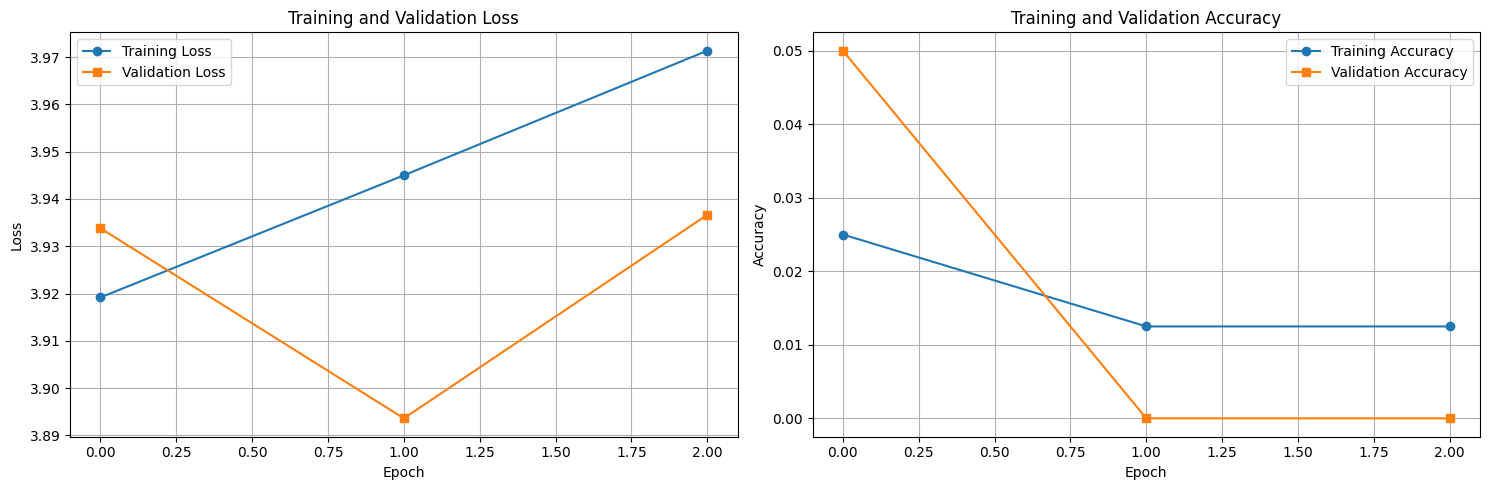

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(train_losses, label='Training Loss', marker='o')
ax1.plot(val_losses, label='Validation Loss', marker='s')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(train_accuracies, label='Training Accuracy', marker='o')
ax2.plot(val_accuracies, label='Validation Accuracy', marker='s')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       2.0
           3       0.00      0.00      0.00       2.0
           6       0.00      0.00      0.00       1.0
           7       0.00      0.00      0.00       1.0
           9       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       1.0
          12       0.00      0.00      0.00       1.0
          17       0.00      0.00      0.00       1.0
          25       0.00      0.00      0.00       1.0
          30       0.00      0.00      0.00       1.0
          36       0.00      0.00      0.00       0.0
          37       0.00      0.00      0.00       1.0
          40       0.00      0.00      0.00       1.0
          41       0.00      0.00      0.00       2.0
          43       0.00      0.00      0.00       1.0
          44       0.00      0.00      0.00       2.0
          45       0.00      0.00      0.00       0.0
   

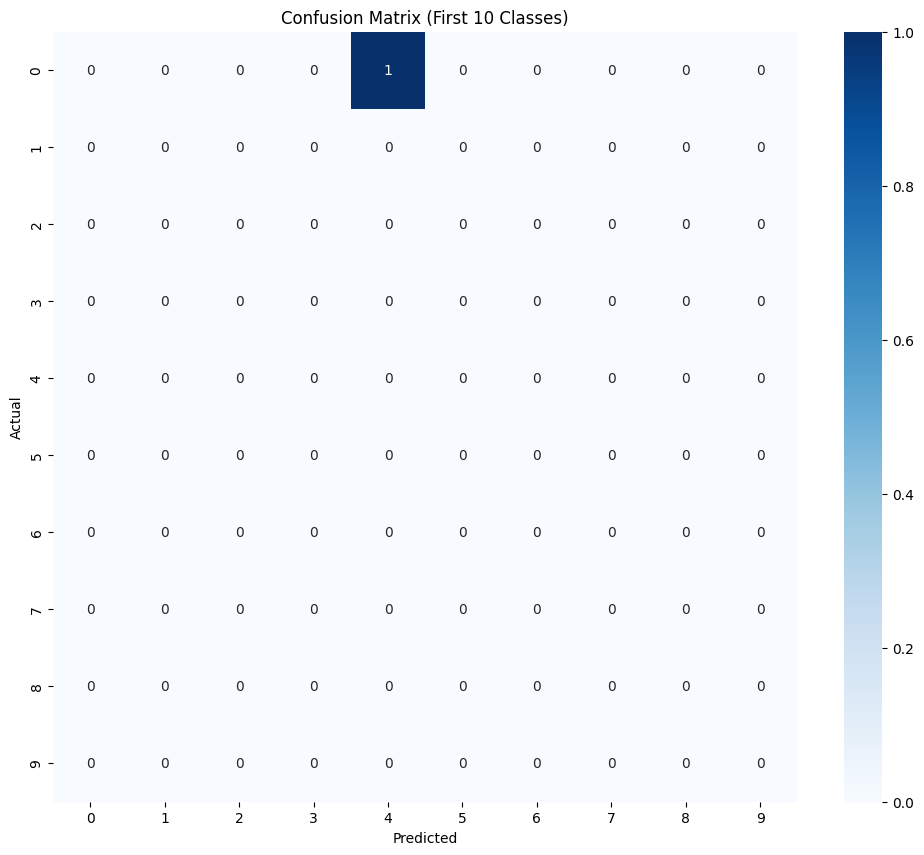


Final Results:
Final Training Accuracy: 0.0125
Final Validation Accuracy: 0.0000


In [13]:
print("\nClassification Report:")
print(classification_report(val_labels, val_preds))

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm[:10, :10], annot=True, fmt='d', cmap='Blues')  # Show subset for clarity
plt.title('Confusion Matrix (First 10 Classes)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"\nFinal Results:")
print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")